# PPCA in TensorFlow Probability - Part 2: Fixing the parameter problem
This is part 2 of the PPCA in TensorFlow Probability. In part 1, we recreated the PPCA from [one of TFP's tutorials](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_PCA.ipynb). Although this enabled us to find some latent dataset $\bar{z}$ from which we could simulate a simular dataset $\bar{x}$, we noticed that our estimated latent dataset $\bar{z}$ was much different from our original latent dataset. In this notebook we try to solve that problem.

First we import necessary libraries

In [1]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from mpl_toolkits.mplot3d import Axes3D

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

tf.enable_v2_behavior()

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

import os
os.sys.path.append('../Python')
from ppca import PPCA
from rotation_check import rotation_check

We create a function of the original $x = Wz$ model as we did before, so that we obtain $z$ again for analysis. Here we specify the model again.

In [8]:
Root = tfd.JointDistributionCoroutine.Root
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                 scale=tf.ones([latent_dim, num_datapoints]),
                 name="z"), reinterpreted_batch_ndims=2))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=sigma,
      name="x"), reinterpreted_batch_ndims=2)

In [9]:
num_datapoints = 10000
data_dim = 3
latent_dim = 2

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)

We utilize the model to achieve our MAP values (although we specify flat priors, so we could refer to them as ML values).

In [10]:
actual_sigma, actual_w, actual_z, x_train = model_basis.sample()

sigma = tf.Variable(1.0, dtype=tf.float32)
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

target_log_prob_fn = lambda sigma, w, z: model_basis.log_prob((sigma, w, z, x_train))
losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=1500)

We use Tippings & Bishops PPCA method for comparison and plot the reproduced values of the observed dataset $x$

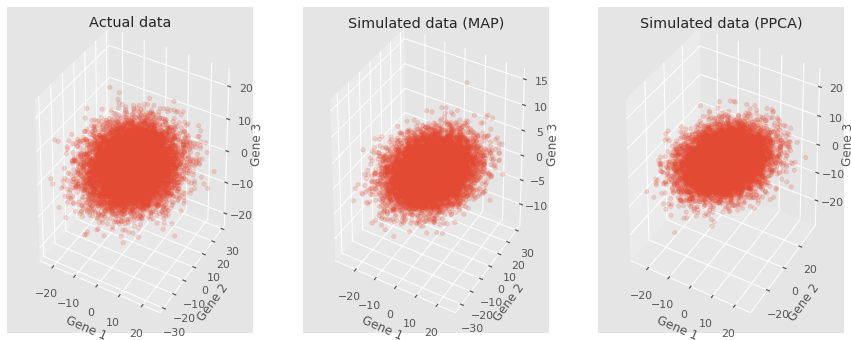

Mean actual data:  [-0.03408068 -0.07816307 -0.05397817] , std.dev:  [6.2487216 8.115859  5.42216  ]
Mean PPCA data:  [-0.08134665 -0.06307995 -0.01361075] , std.dev:  [6.7774096 8.824543  5.899859 ]
Mean TFP data:  [-0.11039524 -0.02787955 -0.00663773] , std.dev:  [6.7658014 8.436095  3.310794 ]


In [11]:
_, _, _, x_generated = model_basis.sample(value=(sigma, w, z, None))

# Bishops PPCA
ppca = PPCA()
ppca.fit(x_train.numpy().T, mu = np.zeros(data_dim)[np.newaxis].T)
mu_ppca, sigma_ppca, w_ppca = ppca.parameters()
z_ppca = np.linalg.lstsq(w_ppca,x_train)[0]
x_ppca = tfd.Normal(loc=tf.matmul(tf.Variable(w_ppca,dtype=tf.float32),tf.Variable(z_ppca,dtype=tf.float32)),scale=sigma,name="x_ppca").sample()

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1,3,1, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,2, projection='3d')
ax.scatter(x_generated[0,:],x_generated[1,:],x_generated[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,3,3, projection='3d')
ax.scatter(x_ppca[0,:],x_ppca[1,:],x_ppca[2,:], alpha=0.2)
ax.set_title('Simulated data (PPCA)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

print('Mean actual data: ', np.mean(x_train, axis=1), ', std.dev: ', np.std(x_train, axis=1))
print('Mean PPCA data: ', np.mean(x_ppca, axis=1), ', std.dev: ', np.std(x_ppca, axis=1))
print('Mean TFP data: ', np.mean(x_generated, axis=1), ', std.dev: ', np.std(x_generated, axis=1))

As we can see, our recfreated $\bar{x}$ has approximately the same mean and standard deviation as the original. Our model thus succeeds in finding a latent space and factor loading matrix that recreates the approximate same data.
In the cell below, we see that the found latent dataset $\bar{z}$ is not the same as the original.

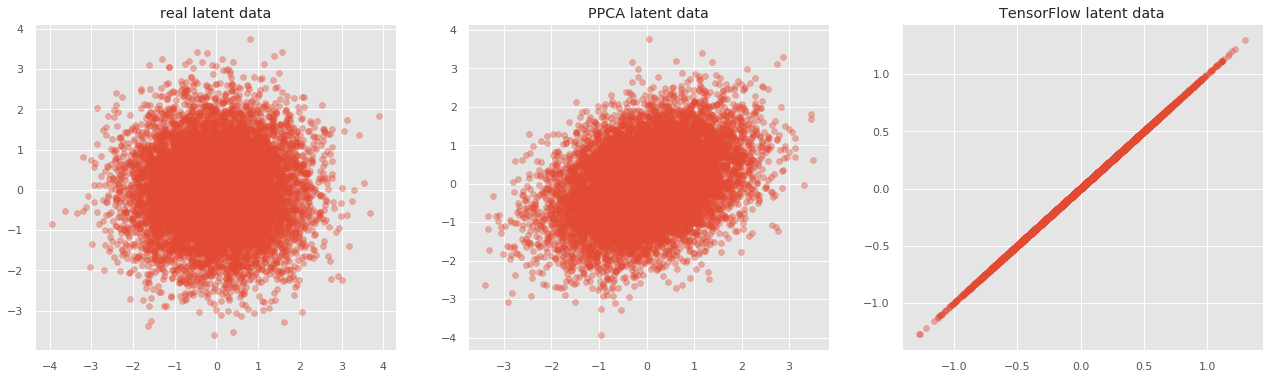

Mean actual latent data:  [ 0.01033707 -0.0071645 ] , std.dev:  [1.0014232 0.9979693] corr. coeff. axes:  0.0015536866756230585
Mean PPCA latent data:  [ 0.0093709  -0.00424673] , std.dev:  [0.97518258 0.9518668 ] corr. coeff. axes:  0.3618543142121971
Mean TFP latent data:  [-0.00293516 -0.00293516] , std.dev:  [0.3538736 0.3538736] corr. coeff. axes:  1.0


In [20]:
z = np.linalg.lstsq(w.numpy(),x_train)[0]

fig = plt.figure(figsize=(22,6))
ax = fig.add_subplot(1,3,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,3,2)
ax.scatter(z_ppca[0,:], z_ppca[1,:], alpha=0.4)
ax.set_title('PPCA latent data')
ax = fig.add_subplot(1,3,3)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(actual_z[0,:],actual_z[1,:])[0,1])
print('Mean PPCA latent data: ', np.mean(z_ppca, axis=1), ', std.dev: ', np.std(z_ppca, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z_ppca[0,:],z_ppca[1,:])[0,1])
print('Mean TFP latent data: ', np.mean(z, axis=1), ', std.dev: ', np.std(z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z[0,:],z[1,:])[0,1])

The PPCA creates a latent dataset $z$ that is similar tot he original in terms of mean and standard deviation, but the axes of the latent dataset show a slight correlation as opposed to the original. This suggests that the found dataset is not optimal in terms of dimension reduction and information preservation.

Strangely, the latent dataset as found by TFP shows a perfect correlation of $1.0$! Apart from this, the data is still zero-centered but has smaller standard deviation. This smaller standard deviation in $z$ is probably compensated by a higher $\sigma^2$ of $\bar{x}$ as we see below.

In [16]:
print('real variance: ', actual_sigma.numpy()**2)
print('PPCA variance: ', sigma_ppca)
print('simulated variance: ', sigma.numpy()**2)
print()
print('real W:\n', actual_w.numpy())
print('PPCA W:\n', w_ppca)
print('simulated W:\n', w.numpy())
print()

real variance:  0.3514963882370381
PPCA variance:  0.3542369217408254
simulated variance:  11.154486201813597

real W:
 [[ 1.105154    6.1284065 ]
 [-1.7184305   7.9360046 ]
 [-5.358062   -0.31442642]]
PPCA W:
 [[-6.02084793 -0.0474076 ]
 [-7.53430438 -1.92216472]
 [-2.74031026  5.38902774]]
simulated W:
 [[ 8.569385    8.569385  ]
 [11.310373   11.310373  ]
 [ 0.11130446  0.11130446]]



Let's take a look at those values of $\bar{z}$ as found by TFP.

In [25]:
print('First latent dimension: ', z[0,:6])
print('Second latent dimension: ', z[1,:6])
print('Are all values equal? ', np.all(z[0,:]==z[1,:]))

First latent dimension:  [ 0.01387834  0.24418297 -0.44047463  0.26984492 -0.18343124  0.18000406]
Second latent dimension:  [ 0.01387834  0.24418297 -0.44047463  0.26984492 -0.18343124  0.18000406]
Are all values equal?  True


As we can see, the values for both dimensions are all exactly equal. If we generate another random sample, this is not the case, so it can not be due to TFP's sampling procedure.

In [30]:
print(tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),scale=tf.ones([latent_dim, num_datapoints])).sample().numpy())

[[-0.23956451 -0.04159369  0.98976135 ... -1.2754954   0.5517286
  -0.9124424 ]
 [-1.2825854  -0.4008666   1.5323112  ... -0.1670349   0.40532807
   1.2641212 ]]


We will try to solve this by explicitely specifying $\bar{z}$ to have independent axes. Note that $z$ is now specified as a multivariate Gaussian with Identity matrices for covariance matrices.

In [69]:
Root = tfd.JointDistributionCoroutine.Root
cov = [tf.eye(num_datapoints) for i in range(latent_dim)]
def probabilistic_pca_basis(data_dim, latent_dim, num_datapoints):
    sigma = yield Root(tfd.Independent(
        tfd.Uniform(low=0, high=5, name='sigma')))
    w = yield Root(tfd.Independent(
        tfd.Uniform(low=-10.0*tf.ones([data_dim, latent_dim]),
                 high=10.0*tf.ones([data_dim, latent_dim]),
                 name="w"), reinterpreted_batch_ndims=2))
    z = yield Root(tfd.Independent(
        tfd.MultivariateNormalFullCovariance(loc=tf.zeros([latent_dim, num_datapoints]),
                 covariance_matrix=cov,
                 name="z")))
    x = yield tfd.Independent(tfd.Normal(
      loc=tf.matmul(w, z),
      scale=sigma,
      name="x"), reinterpreted_batch_ndims=2)

concrete_ppca_model_basis = functools.partial(probabilistic_pca_basis,
    data_dim=data_dim,
    latent_dim=latent_dim,
    num_datapoints=num_datapoints)

model_basis = tfd.JointDistributionCoroutine(concrete_ppca_model_basis)

actual_sigma, actual_w, actual_z, x_train = model_basis.sample()

sigma = tf.Variable(1.0, dtype=tf.float32)
w = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
z = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)

losses = tfp.math.minimize(lambda: -target_log_prob_fn(sigma, w, z),
                           optimizer=tf.optimizers.Adam(learning_rate=0.05),
                           num_steps=500)

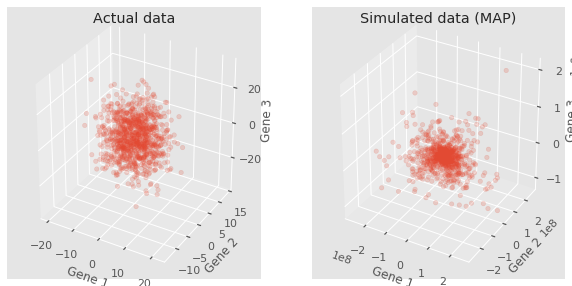

Mean actual data:  [ 0.19205862 -0.06531994 -0.24064924] , std.dev:  [6.4714417 4.7912364 9.828898 ]
Mean TFP data:  [  -180369.34   1012512.9  -19380116.  ] , std.dev:  [6.2705936e+07 4.8396624e+07 3.0250986e+08]


In [79]:
_, _, _, x_generated = model_basis.sample(value=(sigma, w, z, None))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(x_train[0,:],x_train[1,:],x_train[2,:], alpha=0.2)
ax.set_title('Actual data')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(x_generated[0,:],x_generated[1,:],x_generated[2,:], alpha=0.2)
ax.set_title('Simulated data (MAP)')
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

print('Mean actual data: ', np.mean(x_train, axis=1), ', std.dev: ', np.std(x_train, axis=1))
print('Mean TFP data: ', np.mean(x_generated, axis=1), ', std.dev: ', np.std(x_generated, axis=1))

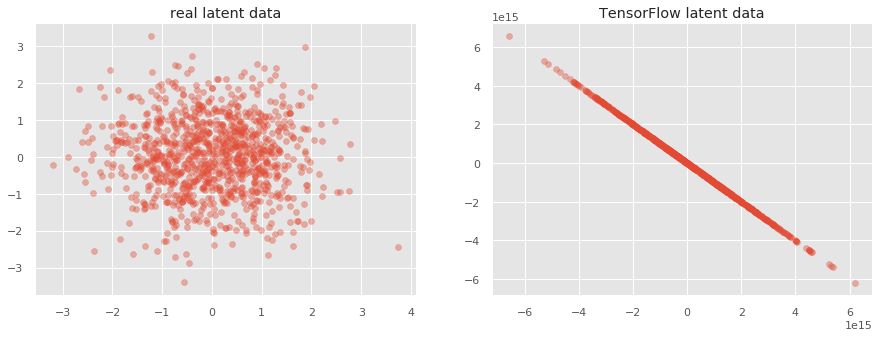

Mean actual latent data:  [-0.01233531  0.0329867 ] , std.dev:  [1.0215386 1.0145831] corr. coeff. axes:  -0.024928494181065707
Mean TFP latent data:  [ 6.6261157e+13 -6.6261157e+13] , std.dev:  [1.7729201e+15 1.7729201e+15] corr. coeff. axes:  -1.0


In [78]:
z = np.linalg.lstsq(w.numpy(),x_train)[0]

fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1,2,1)
ax.scatter(actual_z[0,:], actual_z[1,:], alpha=0.4)
ax.set_title('real latent data')
ax = fig.add_subplot(1,2,2)
ax.scatter(z[0,:], z[1,:], alpha=0.4)
ax.set_title('TensorFlow latent data')
plt.show()

print('Mean actual latent data: ', np.mean(actual_z, axis=1), ', std.dev: ', np.std(actual_z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(actual_z[0,:],actual_z[1,:])[0,1])
print('Mean TFP latent data: ', np.mean(z, axis=1), ', std.dev: ', np.std(z, axis=1), 'corr. coeff. axes: ',
      np.corrcoef(z[0,:],z[1,:])[0,1])

Now $\bar{x}$ and $\bar{z}$ are both very off and the correlation problem still persists.. Unfortunately, we have not succeeded with this try.